# Conversational bot for Madkudu services

The whole idea is to use 

# 1. Load data from Madkudu



In [22]:

from langchain.indexes import VectorstoreIndexCreator

I could have also chosen to download some of these pdf files directly https://support.madkudu.com/hc/en-us/article_attachments/360052888911 Instead of making a crawler

In [23]:

from langchain.document_loaders import TextLoader
loader = TextLoader('all.txt', encoding='utf-8')
documents = loader.load()

# 2. Split data into chunks

RecursiveCharacterTextSplitter is more optimized than the CharacterTextSplitter

In [24]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
#Alternative option
#text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)

text_splitter = RecursiveCharacterTextSplitter(
    #i chose 500 because the data is not that 
    # number of characters
    chunk_size = 500, 
    #How many chars are going to be overlapped in between each chunk
    chunk_overlap = 250,
    
    length_function = len,
    
    #includes index of character where the separation between each chunk is done
    add_start_index = True
    
    )

chunks = text_splitter.split_documents(documents)

The data was split into 113 chunks of 500 chars 

In [25]:
len(chunks)

113

In [26]:
chunks[15].page_content

"Static enrichment: MadKudu partners with Clearbit, HG data, and PredictLeads to enrich your data. Are you already purchasing through ZoomInfo, Bombora, Datafox? No problem, MadKudu can also use this data. \nCRM information: actually any data from your CRM (Leads, Contacts, Accounts, Opportunities), be it provided by a 3rd party or from your Marketing and Sales input, can be pulled to MadKudu's platform."

Source could have been useful if I separated each url into different txt files to have a better documentation. So perhaps I can implement this at the end.

In [27]:
chunks[15].metadata

{'source': 'all.txt', 'start_index': 3951}

In [28]:

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import AutoTokenizer, pipeline
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA

In [29]:
# Define the path to the pre-trained model you want to use
modelPath = "sentence-transformers/all-MiniLM-l6-v2"

# Create a dictionary with model configuration options, specifying to use the CPU for computations
model_kwargs = {'device':'cpu'}

# Create a dictionary with encoding options, specifically setting 'normalize_embeddings' to False
encode_kwargs = {'normalize_embeddings': False}

# Initialize an instance of HuggingFaceEmbeddings with the specified parameters
embeddings = HuggingFaceEmbeddings(
    model_name=modelPath,     # Provide the pre-trained model's path
    model_kwargs=model_kwargs, # Pass the model configuration options
    encode_kwargs=encode_kwargs # Pass the encoding options
)

# 4. Store chunks in FAISS and embed them

Here we are first creating our database with FAISS



In [30]:
db = FAISS.from_documents(chunks, embeddings)

Performing a simple similarity of vectors search

In [31]:
question = " likely to buy"
searchDocs = db.similarity_search(question)
print(searchDocs[0].page_content)

Likelihood to Buy: refers to the output of a behavioral model predicting the level of engagement of a person or account. 
Lift (Conversion lift): impact on conversion compared to the average population. 
A positive lift shows a positive impact on conversion of having this trait, or performing this action 
A negative life shows a negative impact on conversion of having this trait or performing this action


# 5. Creating the model 

I am choosing a question and answering pretrained model

In [32]:
# Create a tokenizer object by loading the pretrained "Intel/dynamic_tinybert" tokenizer.
tokenizer = AutoTokenizer.from_pretrained("Intel/dynamic_tinybert")

# Create a question-answering model object by loading the pretrained "Intel/dynamic_tinybert" model.
model = AutoModelForQuestionAnswering.from_pretrained("Intel/dynamic_tinybert")

In [33]:
# Specify the model name you want to use
model_name = "Intel/dynamic_tinybert"

# Load the tokenizer associated with the specified model
tokenizer = AutoTokenizer.from_pretrained(model_name, padding=True, truncation=True, max_length=512)

# Define a question-answering pipeline using the model and tokenizer
question_answerer = pipeline(
    "question-answering", 
    model=model_name, 
    tokenizer=tokenizer,
    #pytorch tensors
    return_tensors='pt'
)

# Create an instance of the HuggingFacePipeline, which wraps the question-answering pipeline
# with additional model-specific arguments (temperature and max_length)
llm = HuggingFacePipeline(
    pipeline=question_answerer,
    model_kwargs={"temperature": 0.7, "max_length": 512},
)

# 6. Retrieving
Once the data is in FAISS, the LLM model is prepared, and the pipeline is created, we need to retrieve the data. A retriever is an interface that returns documents from the database(FAISS)

In [34]:
retriever = db.as_retriever()
docs = retriever.get_relevant_documents("what is likelihood to buy")
print(docs[0].page_content)

Likelihood to Buy: refers to the output of a behavioral model predicting the level of engagement of a person or account. 
Lift (Conversion lift): impact on conversion compared to the average population. 
A positive lift shows a positive impact on conversion of having this trait, or performing this action 
A negative life shows a negative impact on conversion of having this trait or performing this action


# 7. Retrieval QA chain

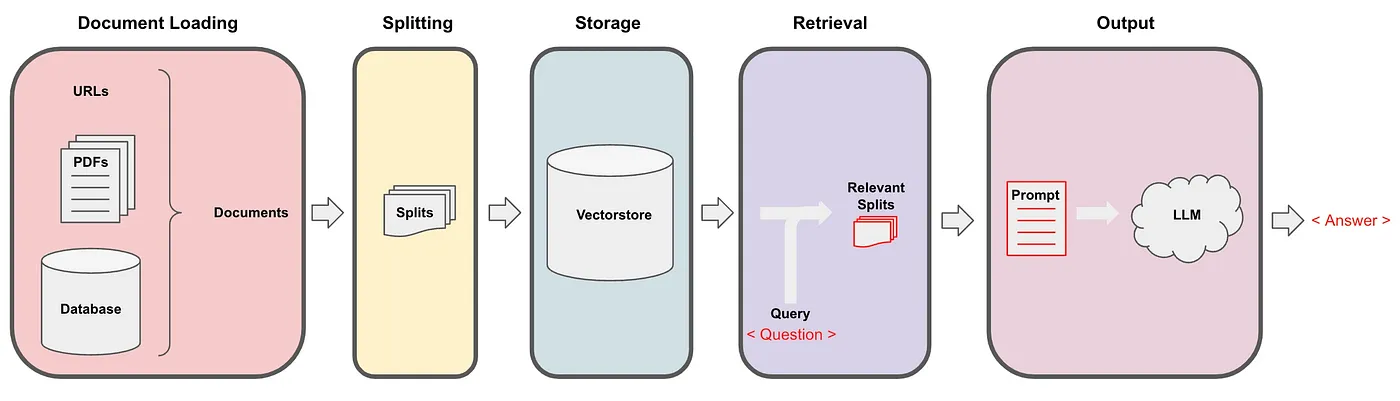

The retrieval QA basically puts together the:
- Retriver - I chose 3 chunks because we have few data already
- The LL model which already contains our pipeline


In [35]:
# recreate a retriever object from the 'db' with a search configuration where it retrieves up to 3 relevant chunks.
retriever = db.as_retriever(search_kwargs={"k": 3})

# Create a question-answering instance (qa) using the RetrievalQA class.
# It's configured with a language model (llm), a chain type "refine," the retriever we created, and an option to not return source documents.
qa = RetrievalQA.from_chain_type(llm=llm, chain_type="refine", retriever=retriever, return_source_documents=False)

In [37]:
question = "What is likelihood to buy?"
result = qa.run({"query": question})
print(result["result"])

ValueError: Context information is below. 
------------
Likelihood to Buy: refers to the output of a behavioral model predicting the level of engagement of a person or account. 
Lift (Conversion lift): impact on conversion compared to the average population. 
A positive lift shows a positive impact on conversion of having this trait, or performing this action 
A negative life shows a negative impact on conversion of having this trait or performing this action
------------
Given the context information and not prior knowledge, answer the question: What is likelihood to buy?
 argument needs to be of type (SquadExample, dict)

In [ ]:
print(result["result"])

NameError: name 'result' is not defined